In [3]:
import pandas as pd
import spacy
import numpy as np
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from bs4 import BeautifulSoup



In [4]:
df_articles = pd.read_csv('sävsjö_articles.csv')
df_articles.head()
df_articles = df_articles.dropna()
df_articles.head()

,ID,Title,Text
0,2,Aktiespararna säger ja till Gunvorbudet<span> ...,Aktiespararna rekommenderar sina medlemmar att...
2,7,Man fast i en timme i grop<span> - kuriren.nu<...,En man i 60-årsåldern föll ner i en grop som v...
3,8,Mannen fastnade i en grop  i flera timmar<spa...,En man i 60-årsåldern trillade ner i ett grävt...
4,56,En motorcykel,Här är den längre versionen.
5,66,Stulna braskaminer för 50 000 ska värma,Det börjar bli vinter och kallt. Då är det skö...


In [5]:
for col in df_articles.columns[1:]:
    df_articles[col] = df_articles[col].astype(str)
    df_articles[col] = df_articles[col].apply(lambda x: BeautifulSoup(x).get_text())
df_articles = df_articles.replace(r'[^\w\s]|_', '', regex=True)

/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [6]:
nlp = spacy.load("sv_core_news_lg")
stopwords = nlp.Defaults.stop_words

In [7]:
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
ent_remove = ['LOC','TME','MSR']
tokens = []
entities = []
i = 0 
for summary in nlp.pipe(df_articles['Text']):
   proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha and token.lemma_.lower() and token.ent_type_ not in ent_remove]
   ents = list(dict.fromkeys([ent.text.lower() for ent in summary.ents if ent.label_ not in ent_remove]))
   for ent in ents:
      if ent not in proj_tok:
         proj_tok.append(ent)
   tokens.append(proj_tok)
   entities.append(ents)
   

In [18]:
df_copy = df_articles.copy()
df_copy['tokens'] = tokens
df_copy['entities'] = entities
df_copy.iloc[5]['tokens']

['ny',
 'skolchef',
 'heta',
 'stefan',
 'claesson',
 'jobba',
 'börja',
 'basa',
 'läre',
 'elev',
 'vara',
 'klar',
 'vara',
 'förhandlingsfråga',
 'ny',
 'skolchef',
 'hittillsvarande',
 'arbetsgivare',
 'stefan claesson']

In [83]:
from gensim.models import TfidfModel
vocab = Dictionary(df_copy['tokens'])
len(vocab.token2id)
bagOfWords = [vocab.doc2bow(i) for i in df_copy['tokens']]

# Filter reduntant tokens based on tfidf score/ Then filter extreme values and keep top 2000 tokens for modelling
def tfidf_filtering(df,corpus,vocab):
    tfidf = TfidfModel(bagOfWords, id2word=vocab)
    tfidf[bagOfWords]
    # ents2id = df['entities'].apply(lambda x: [vocab.token2id[tok] for tok in x]).tolist()   
    
    low_value = 0.05
    low_value_words = []
    
    for i in range(0,len(bagOfWords)):
        # low_value_words += [id for id, value in tfidf[bagOfWords[i]] if value < low_value and id not in ents2id[i]] 
        low_value_words += [id for id, value in tfidf[bagOfWords[i]] if value < low_value and id] 
    vocab.filter_tokens(bad_ids=low_value_words)
    return vocab
    
filtered_vocab = tfidf_filtering(df_copy,bagOfWords,vocab)
filtered_vocab.filter_extremes(no_below=2, no_above=0.4)
len(filtered_vocab)


25954

In [84]:
corpus =  [filtered_vocab.doc2bow(i) for i in df_copy['tokens']]
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1)],
 [(4, 1), (6, 1)],
 [],
 [(7, 1)],
 [(8, 1), (9, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1)],
 [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1)],
 [],
 [],
 [],
 [],
 [],
 [],
 [(21, 1)],
 [(22, 1), (23, 1)],
 [(24, 1), (25, 1)],
 [(26, 1), (27, 1), (28, 1)],
 [(29, 1), (30, 1), (31, 1), (32, 1)],
 [(33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)],
 [(41, 1), (42, 1), (43, 1)],
 [(44, 1), (45, 1), (46, 1), (47, 1), (48, 1)],
 [(49, 1), (50, 1), (51, 1)],
 [],
 [(52, 1), (53, 1), (54, 1), (55, 1)],
 [(56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)],
 [(63, 1), (64, 1), (65, 1), (66, 1)],
 [(67, 1)],
 [(68, 1), (69, 1)],
 [(70, 1), (71, 1), (72, 1), (73, 1)],
 [(74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1)],
 [(82, 1), (83, 1), (84, 1)],
 [(85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1)],
 [(64, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1)],
 [

In [85]:
filtered_vocab.token2id

{'group': 0,
 'gunvor': 1,
 'rekommenderar': 2,
 'timber': 3,
 'grop': 4,
 'grävd': 5,
 'trilla': 6,
 'braskamin': 7,
 'basa': 8,
 'hittillsvarande': 9,
 'krösatåg': 10,
 'signalfel': 11,
 'stoppet': 12,
 'synnerhet': 13,
 'irritera': 14,
 'multisjuk': 15,
 'orion': 16,
 'ryta': 17,
 'spf orion': 18,
 'tiga': 19,
 'östvästlig': 20,
 'testing': 21,
 'inbrottstjuev': 22,
 'tjuv': 23,
 'dik': 24,
 'halt': 25,
 'dyrbar': 26,
 'inhägna': 27,
 'ståe': 28,
 'avsändare': 29,
 'bedrägeriförsök': 30,
 'euro': 31,
 'faktura': 32,
 'bromé': 33,
 'folkkär': 34,
 'fotografering': 35,
 'nostalgisk': 36,
 'noterna': 37,
 'showen': 38,
 'tillbakablick': 39,
 'äntrad': 40,
 'avnjuta': 41,
 'lottning': 42,
 'luciakandidat': 43,
 'iogtntos': 44,
 'towe': 45,
 'towe widerberg': 46,
 'underhålla': 47,
 'widerberg': 48,
 'kollekt': 49,
 'musikskolans': 50,
 'världen': 51,
 'debuten': 52,
 'hemkomm': 53,
 'mersmak': 54,
 'stapel': 55,
 'cigarett': 56,
 'halvtvåtid': 57,
 'icabutik': 58,
 'läsk': 59,
 'påträff

In [86]:
LDA_Model = LdaMulticore(corpus=corpus, id2word=filtered_vocab, iterations=50 , num_topics=4, workers = 4, passes=10)

In [87]:
LDA_Model.print_topics()


[(0,
  '0.002*"virusvariant" + 0.001*"veronika" + 0.001*"provta" + 0.001*"brygga" + 0.001*"ovaccinera" + 0.001*"ansträng" + 0.001*"smittskyddsläkare" + 0.001*"rubricera" + 0.001*"virus" + 0.001*"greps"'),
 (1,
  '0.003*"påfyllnadsdos" + 0.002*"odling" + 0.002*"kulturskola" + 0.002*"ranking" + 0.002*"sibylla" + 0.002*"tegnell" + 0.001*"skatepark" + 0.001*"nato" + 0.001*"smittskyddsläkare" + 0.001*"akutsjukhus"'),
 (2,
  '0.003*"gevär" + 0.002*"podd" + 0.002*"luciatåg" + 0.002*"singelolycka" + 0.001*"tillställning" + 0.001*"vaccinationsbevis" + 0.001*"backstig" + 0.001*"rosander" + 0.001*"smittskyddsåtgärd" + 0.001*"brukare"'),
 (3,
  '0.002*"wiksten" + 0.001*"byalag" + 0.001*"elpris" + 0.001*"agnevik" + 0.001*"presstalesperson" + 0.001*"greps" + 0.001*"rubricera" + 0.001*"sommarjobb" + 0.001*"familjehem" + 0.001*"larmaa"')]

In [88]:
# Lemmatized articles as lists of tokens
lemmatized = df_copy['tokens'].tolist()

In [89]:
coherencemodel = CoherenceModel(model=LDA_Model, texts=lemmatized, dictionary=filtered_vocab, coherence='c_v')
baseline_coherence = coherencemodel.get_coherence()
print(f'Coherence value for baseline model: {baseline_coherence}')

Coherence value for baseline model: 0.6668589460635234


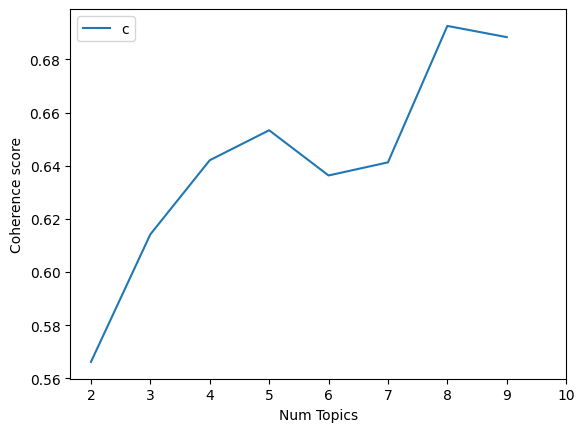

In [90]:
import matplotlib.pyplot as plt

# Compute coherence values for different numbers of topics 
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=filtered_vocab, iterations=50,chunksize= 200, num_topics= num_topics, workers = 4, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=filtered_vocab , corpus=corpus, texts=lemmatized, start=2, limit=10, step=1)

# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xticks(range(start,limit + 1))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [91]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
optimal_score = coherence_values[best_result_index]
diff_from_base = optimal_score - baseline_coherence

In [92]:
print(f'''Optimal number of topics for the LDA model: {x[best_result_index]}\nCoherence Score: {optimal_score}''')
print(f'Coherent improvement: {diff_from_base}')
# Get top topic for a specific bag-of-words formatted text
def top_topic(bow):
    topic_dict = {}
    for topic in bow:
        topic_dict[topic[0]]= topic[1]
    top_topic = sorted(topic_dict.items(),key=lambda x: x[1],reverse=True)[0][0]
    return top_topic

df_copy['topic'] = [top_topic(optimal_model[corpus][i]) for i in range(len(df_copy['Text']))]
df_copy.head(15)

Optimal number of topics for the LDA model: 8
Coherence Score: 0.692628078044236
Coherent improvement: 0.025769131980712623


,ID,Title,Text,tokens,entities,topic
0,2,Aktiespararna säger ja till Gunvorbudet dise,Aktiespararna rekommenderar sina medlemmar att...,"[aktiespararna, rekommenderar, medlem, anta, b...",[gunvor group],3
2,7,Man fast i en timme i grop kurirennu,En man i 60årsåldern föll ner i en grop som va...,"[föll, grop, grävd, egen, tomt, timme, ligga, ...",[],7
3,8,Mannen fastnade i en grop i flera timmar exp...,En man i 60årsåldern trillade ner i ett grävt ...,"[trilla, gräva, hål, tomt, grop, stund, hitta,...",[david],7
4,56,En motorcykel,Här är den längre versionen,"[vara, version]",[],0
5,66,Stulna braskaminer för 50 000 ska värma,Det börjar bli vinter och kallt Då är det skön...,"[börja, vinter, vara, skönt, braskamin, visste...",[],6
6,67,Sävsjö får ny skolchef,Sävsjö kommun ska få en ny skolchef Han heter ...,"[ny, skolchef, heta, stefan, claesson, jobba, ...",[stefan claesson],0
7,70,Krösatågen kan bli försenade,Ett signalfel på sträckan SödertäljeStockholm ...,"[signalfel, sträcka, satte, stopp, tågtrafik, ...",[länstrafiken],7
8,72,Sävsjöpensionärer gör uppror,Stora grupper av pensionärer i Sävsjö är på kr...,"[grupp, pensionär, vara, krigsstig, landsting,...",[spf orion],7
9,78,Linus testar,Ett test jdklsa jfkldsa sjfkldsaö jfklsdaöjfls...,"[test, jfkldsa, sjfkldsaö]",[],0
10,79,Linus testar 2,Testar 2,[testa],[],0


In [93]:
display = pyLDAvis.gensim_models.prepare(optimal_model, corpus, optimal_model.id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(display)


/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importli

In [94]:
optimal_model.print_topics()

[(0,
  '0.004*"julklapp" + 0.004*"sibylla" + 0.003*"peo" + 0.003*"provsvar" + 0.002*"usm" + 0.002*"floengård" + 0.002*"familjehem" + 0.002*"generaldirektör" + 0.002*"enduro" + 0.002*"nordic"'),
 (1,
  '0.004*"msb" + 0.003*"luciatåg" + 0.003*"ranking" + 0.003*"singelolycka" + 0.003*"dik" + 0.003*"tegnell" + 0.003*"larmad" + 0.003*"insatsledare" + 0.003*"ireståhl" + 0.002*"avlidit"'),
 (2,
  '0.003*"veronika" + 0.003*"woentin" + 0.002*"zettergren" + 0.002*"akutsjukhus" + 0.002*"bårhus" + 0.002*"obos" + 0.002*"hjelmland" + 0.002*"bojestig" + 0.002*"åtala" + 0.002*"ingemar"'),
 (3,
  '0.005*"gevär" + 0.004*"bengnér" + 0.004*"podd" + 0.004*"smittskyddsläkare" + 0.004*"veronika" + 0.003*"stadsfest" + 0.003*"atraktor" + 0.003*"scout" + 0.002*"malin bengnér" + 0.002*"utbrott"'),
 (4,
  '0.004*"virus" + 0.003*"tegnell" + 0.003*"kulturskola" + 0.003*"scb" + 0.003*"virusvariant" + 0.002*"leandersson" + 0.002*"rosander" + 0.002*"musikundervisning" + 0.002*"kensingsvensson" + 0.002*"ristipparna"'),

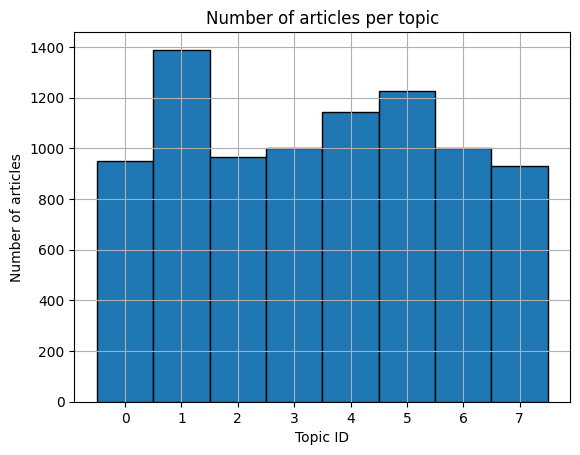

In [95]:
from matplotlib import pyplot as py


def plot_topic_hist(df, best_result_index):
    plt.xlabel('Topic ID')
    plt.ylabel('Number of articles')
    plt.title('Number of articles per topic')
    plt.gca().set_xticks(range(best_result_index))
    hist = df['topic'].hist(bins = np.arange(best_result_index+1)-0.5,edgecolor = "black")
    
plot_topic_hist(df_copy, x[best_result_index])


In [96]:
# Manually tuning initial LDA
display = pyLDAvis.gensim_models.prepare(LDA_Model, corpus, LDA_Model.id2word)
pyLDAvis.enable_notebook()
pyLDAvis.display(display)



/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [100]:
df_copy['topic'] = [top_topic(LDA_Model[corpus][i]) for i in range(len(df_copy['Text']))]
df_copy.head(15)

,ID,Title,Text,tokens,entities,topic
0,2,Aktiespararna säger ja till Gunvorbudet dise,Aktiespararna rekommenderar sina medlemmar att...,"[aktiespararna, rekommenderar, medlem, anta, b...",[gunvor group],0
2,7,Man fast i en timme i grop kurirennu,En man i 60årsåldern föll ner i en grop som va...,"[föll, grop, grävd, egen, tomt, timme, ligga, ...",[],3
3,8,Mannen fastnade i en grop i flera timmar exp...,En man i 60årsåldern trillade ner i ett grävt ...,"[trilla, gräva, hål, tomt, grop, stund, hitta,...",[david],0
4,56,En motorcykel,Här är den längre versionen,"[vara, version]",[],0
5,66,Stulna braskaminer för 50 000 ska värma,Det börjar bli vinter och kallt Då är det skön...,"[börja, vinter, vara, skönt, braskamin, visste...",[],0
6,67,Sävsjö får ny skolchef,Sävsjö kommun ska få en ny skolchef Han heter ...,"[ny, skolchef, heta, stefan, claesson, jobba, ...",[stefan claesson],2
7,70,Krösatågen kan bli försenade,Ett signalfel på sträckan SödertäljeStockholm ...,"[signalfel, sträcka, satte, stopp, tågtrafik, ...",[länstrafiken],3
8,72,Sävsjöpensionärer gör uppror,Stora grupper av pensionärer i Sävsjö är på kr...,"[grupp, pensionär, vara, krigsstig, landsting,...",[spf orion],3
9,78,Linus testar,Ett test jdklsa jfkldsa sjfkldsaö jfklsdaöjfls...,"[test, jfkldsa, sjfkldsaö]",[],0
10,79,Linus testar 2,Testar 2,[testa],[],0


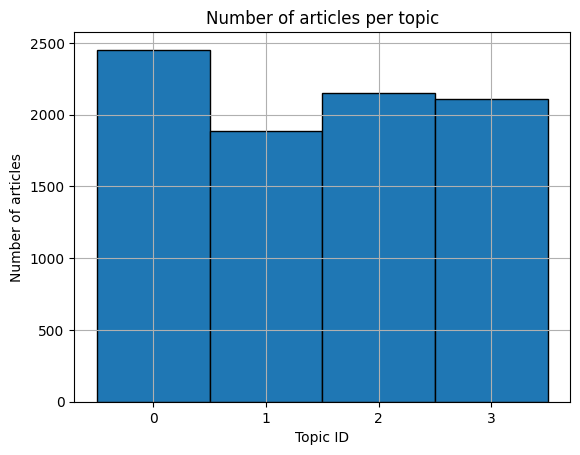

In [101]:
plot_topic_hist(df_copy,4)